In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm, powerlaw
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.coordinates import Galactocentric, galactocentric_frame_defaults, ICRS, SkyCoord
from Functions.PM_functions import *
from Functions.PM_tests import *
# %run Coordinate_Convert_Function.ipynb

Star moving parallel to sun test passed
Star at equator with v_phi=0 test passed


In [2]:
# Probability distribution function from paper
def P(v_phi, SD_phi, constant, b_0):
    return constant * math.exp(v_phi*b_0)**2 / (2*SD_phi**2)

def SD(v_phi, b_arr):
    return b_arr[1] + b_arr[2]*v_phi/100 + b_arr[3]*(v_phi/100)**2 + b_arr[4]*(v_phi/100)**3
    

(array([1.67178985e-06, 2.08973732e-06, 2.08973732e-06, 5.43331703e-06,
        9.19484420e-06, 7.94100181e-06, 1.21204764e-05, 1.42102138e-05,
        1.83896884e-05, 2.84204275e-05, 2.75845326e-05, 3.51075869e-05,
        3.67793768e-05, 5.26613804e-05, 5.55870127e-05, 5.80946974e-05,
        7.27228587e-05, 7.48125960e-05, 8.10818079e-05, 8.73510199e-05,
        9.77997065e-05, 1.17861185e-04, 1.21204764e-04, 1.32907293e-04,
        1.44191875e-04, 1.54222614e-04, 1.61327721e-04, 1.81807147e-04,
        1.95181465e-04, 2.15660891e-04, 2.41155686e-04, 2.05630152e-04,
        2.56619743e-04, 2.73337641e-04, 2.85040170e-04, 2.85876065e-04,
        3.01758069e-04, 3.09281123e-04, 3.40209235e-04, 3.79078349e-04,
        3.67375820e-04, 4.27560255e-04, 4.38844837e-04, 4.40516627e-04,
        4.28396150e-04, 4.43024311e-04, 5.00283114e-04, 5.11149748e-04,
        5.23688172e-04, 5.60885496e-04, 5.94321293e-04, 6.11457139e-04,
        6.36533987e-04, 6.55341623e-04, 7.00479949e-04, 6.950466

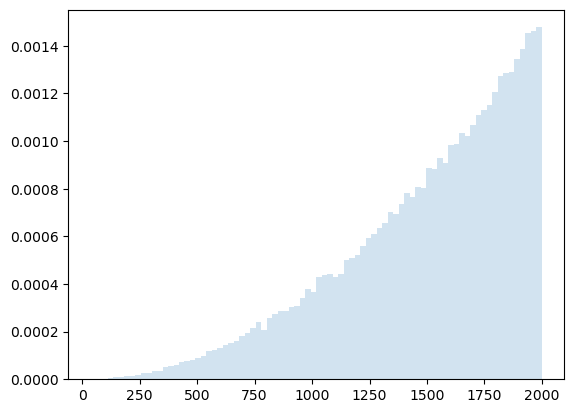

In [3]:
seed_val = 3
rng = np.random.default_rng(seed_val)

# (U0, V0, W0,) = (11.1, 12.24, 7.25) km/s
U0 = 11.1
V0 = 12.24
W0 = 7.25

Theta_0 = 220 #km/s
v_phi_sun = Theta_0 + 12.24 # km/s

a0 = 0.587
a1 = 1.153
a5 = 0.711
b_list = [224.9, 69.5, -44.33, 10.68, -0.73] 

mean_v_phi = 220.1
mean_v_R = 0
mean_v_z = 0

SD_R = 30*a1 # km/s
SD_Z = 30*a5 #km/s
SD_phi = SD(mean_v_phi, b_list)

sample_size = 100000

galcen_params = dict(galcen_v_sun=np.array([U0, Theta_0 + V0, W0]) * u.km/u.s, galcen_distance=8*u.kpc)

# sample ra (deg) and dec (deg) -> uniform, distance (pc) -> power law
# right ascension 
ra = rng.uniform(0, 360, sample_size)
# declination
# sin -1 to 1 -> test histograms of ra and dec independently
sin_dec = rng.uniform(-1, 1, sample_size)
dec = np.rad2deg(np.arcsin(sin_dec))

# distance
a = 3
max_radius = 2000
# TODO: MAKE DISTANCE DISTRIBUTION might want to change later?

# distance = 100
radial_dist = powerlaw(a, scale=max_radius)
distance = radial_dist.rvs(size=sample_size, random_state=rng)

# Making Distributions
# --------------------------------------------------------------------------------------------------------------------
v_R_dist = norm(loc=mean_v_R, scale=SD_R)
v_phi_dist = norm(loc=mean_v_phi, scale=SD_phi)
v_z_dist = norm(loc=mean_v_z, scale=SD_Z)
    
v_R = v_R_dist.rvs(size=sample_size, random_state=rng)
v_phi = v_phi_dist.rvs(size=sample_size, random_state=rng)
v_z = v_R_dist.rvs(size=sample_size, random_state=rng)
plt.hist(distance, density=True,bins='auto', histtype='stepfilled', alpha=0.2)



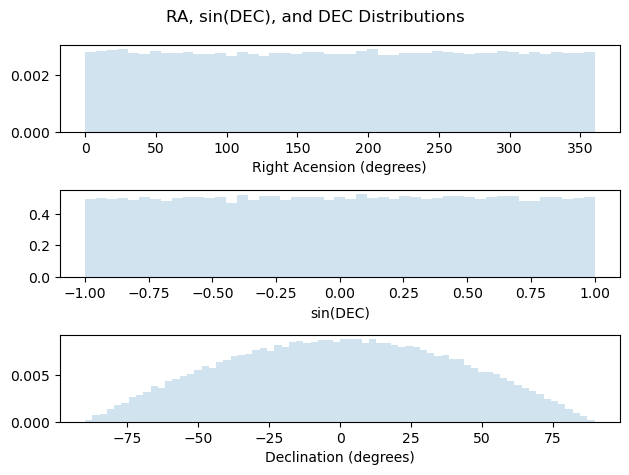

In [4]:

fig, ax = plt.subplots(3)
fig.suptitle("RA, sin(DEC), and DEC Distributions")
ax[0].hist(ra, density=True, bins='auto', histtype='stepfilled', alpha=0.2)
ax[0].set_xlabel("Right Acension (degrees)")
ax[1].hist(sin_dec, density=True, bins='auto', histtype='stepfilled', alpha=0.2)
ax[1].set_xlabel("sin(DEC)")
ax[2].hist(dec, density=True, bins='auto', histtype='stepfilled', alpha=0.2)
ax[2].set_xlabel("Declination (degrees)")
fig.tight_layout()
plt.show()


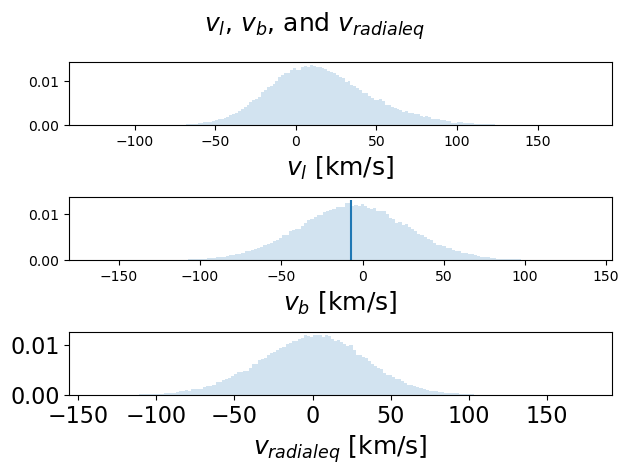

In [5]:
# Sample pm in mas/yr
galactic_data_list = convert_vel_to_pm(ra=ra, dec=dec, distance=distance, v_R=v_R, v_phi=v_phi, v_z=v_z).transform_to(Galactic())
# pm_ra = icrs_data_list.pm_ra_cosdec
# pm_dec = icrs_data_list.pm_dec


# v = distance (pc -> km) * pm (arcsec/year -> sec)
# v_ra = (distance*u.pc).to(u.km)*(pm_ra.to(u.rad/u.s))/u.rad
# v_dec = (distance*u.pc).to(u.km)*(pm_dec.to(u.rad/u.s))/u.rad
# v_radial_eq = (icrs_data_list.radial_velocity).to(u.km/u.s)

# pm_l_cosb, pm_b, radial_velocity
pm_l = galactic_data_list.pm_l_cosb
pm_b = galactic_data_list.pm_b 

v_l = (distance*u.pc).to(u.km)*(pm_l.to(u.rad/u.s))/u.rad
v_b = (distance*u.pc).to(u.km)*(pm_b.to(u.rad/u.s))/u.rad
v_radial_eq = (galactic_data_list.radial_velocity).to(u.km/u.s)

fig, ax = plt.subplots(3)
fig.suptitle("$v_{l}$, $v_{b}$, and $v_{radial eq}$", fontsize=18)
ax[0].hist(v_l, density=True, bins='auto', histtype='stepfilled', alpha=0.2)
ax[0].set_xlabel("$v_{l}$ [km/s]", fontsize=18)
ax[1].hist(v_b, density=True, bins='auto', histtype='stepfilled', alpha=0.2)
ax[1].set_xlabel("$v_{b}$ [km/s]", fontsize=18)
ax[2].hist(v_radial_eq, density=True, bins='auto', histtype='stepfilled', alpha=0.2)
ax[2].set_xlabel("$v_{radial eq}$ [km/s]", fontsize=18)
ax[1].vlines(-W0, *ax[1].get_ylim())
plt.tick_params(axis='both', labelsize=16)

fig.tight_layout()
plt.savefig("vel.png", dpi=600)
plt.show()

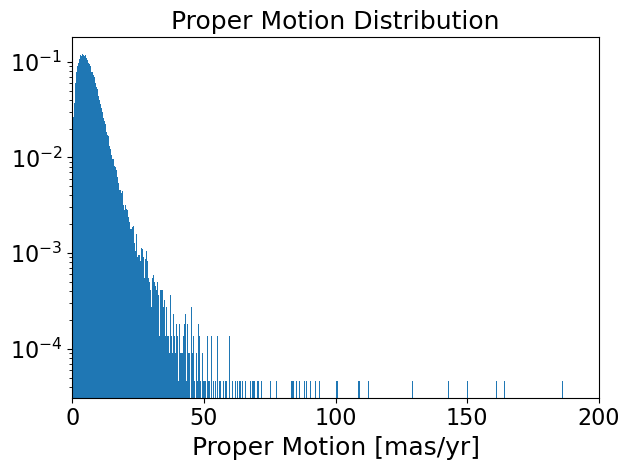

In [16]:
pm = np.sqrt(pm_l.value**2 + pm_b.value**2)
# pm_neg = -np.sqrt(pm_l.value**2 + pm_b.value**2)
# pm = np.append(pm_neg, pm_pos)
plt.hist(pm, density=True, bins='auto', histtype='bar')
plt.xlabel("Proper Motion [mas/yr]", fontsize=18)
plt.yscale("log")
plt.xlim(0,200)
plt.tick_params(axis='both', labelsize=16)
plt.title("Proper Motion Distribution", fontsize=18)
plt.tight_layout()
plt.savefig("pm_dist.png", dpi=600)
plt.show()
# pm.size
# print(np.max(pm))


(array([3.60509638e-05, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 3.60509638e-05]),
 array([-156.3354008 , -156.0580157 , -155.78063061, ...,  202.32352631,
         202.6009114 ,  202.8782965 ]),
 [<matplotlib.patches.Polygon at 0x2298231ea10>])

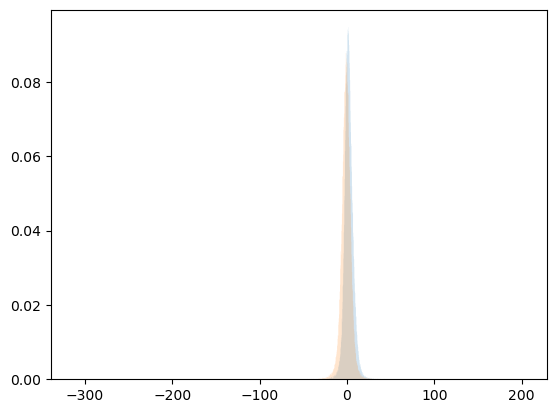

In [7]:
plt.hist(pm_l, density=True, bins='auto', histtype='stepfilled', alpha=0.2)
plt.hist(pm_b, density=True, bins='auto', histtype='stepfilled', alpha=0.2)
